In [43]:
# This script implements the "TRF for Alice EEG Dataset" pipeline as described in the paper.

from pathlib import Path
import re
from matplotlib import pyplot

import numpy as np
from scipy.io import loadmat
from scipy.signal import resample

import mne
from mne import find_events
from mne.channels import make_dig_montage
import eelbrain

import pickle
import os

# Define the dataset root; replace it with the proper path if you downloaded the dataset in a different location
DATA_ROOT = Path('')

# Define paths that will be used throughout
STIMULUS_DIR = DATA_ROOT / 'diliBach_wav_4dryad'
EEG_DIR = DATA_ROOT / 'diliBach_4dryad_CND'

# Load the raw EEG file for a single subject and a specified frequency band
# Adjust subject index and the low/high frequency values accordingly
# To replicate the study, run this script for each subject across all four frequency bands
SUBJECT = 'Sub19'
LOW_FREQUENCY = 4
HIGH_FREQUENCY = 8

In [37]:
# Load EEG data from one subject
def load_subject_raw_eeg(filepath, subject):
    
    # Extract subject index from string (e.g., 'S18' -> 18)
    subject_idx = int(subject[3:])
        
    # Load the .mat file
    mat_data = loadmat(filepath, struct_as_record=False, squeeze_me=True)
    eeg = mat_data["eeg"]
    target_fs = 500  # Target sampling frequency
    orig_fs = int(eeg.fs)
    resample_needed = orig_fs != target_fs
    for i in range(len(eeg.data)):
        
        # Scale data 
        trial_data = 100 * eeg.data[i].astype(np.float32) / np.iinfo(np.int32).max
        
        # Resample to 500Hz, to be consistent with Alice
        if resample_needed:
            n_samples = int(trial_data.shape[0] * target_fs / orig_fs)
            trial_data = resample(trial_data, n_samples, axis=0)
        
        eeg.data[i] = trial_data
        
    # Extract key information into a dictionary
    raw_data = {
        'trials': eeg.data,
        'fs': target_fs,
        'chanlocs': eeg.chanlocs,
        'pad_start': int(eeg.paddingStartSample * target_fs / orig_fs) if resample_needed else int(eeg.paddingStartSample),
        'subject_type': 'Musician' if subject_idx >= 11 else 'Non-musician'
    }
    
    print(f"✓ Loaded {raw_data['subject_type']} (Subject {subject})")
    print(f"  - {len(raw_data['trials'])} trials, {raw_data['trials'][0].shape[1]} channels")
    
    return raw_data


def create_mne_raw_from_loaded(subject_data):
    """Convert already-loaded Bach data to MNE Raw object with channel positions."""
    
    trials = subject_data['trials']
    sfreq = subject_data['fs']
    pad_start = subject_data['pad_start']    
    chanlocs = subject_data['chanlocs']
    
    # Get channel names and positions
    ch_names = []
    positions = []
    
    for ch in chanlocs:
        
        # Get channel label        
        ch_names.append(ch.labels)
        
        # Get channel positions if available
        if hasattr(ch, 'X') and hasattr(ch, 'Y') and hasattr(ch, 'Z'):
            positions.append([ch.Y, ch.X, ch.Z])
    
    # Concatenate all trials
    all_trials = []
    trial_lengths = []
    
    for trial in trials:
        # Remove padding and transpose to channels x time
        trial_clean = trial[pad_start:, :].T
        all_trials.append(trial_clean)
        trial_lengths.append(trial_clean.shape[1])
    
    # Concatenate
    eeg_continuous = np.hstack(all_trials)
    n_channels, n_samples = eeg_continuous.shape
    
    # Create stimulus channel with trial markers
    stim_data = np.zeros((1, n_samples))
    
    # Mark all 30 trial onsets
    current_sample = 0
    marker_positions = []
    for i in range(30):
        # Place marker at current position (offset by 1 if at sample 0)
        marker_sample = 1 if current_sample == 0 else current_sample
        stim_data[0, marker_sample] = i + 1  # Use 1-30 as event IDs
        marker_positions.append((i+1, marker_sample))
        current_sample += trial_lengths[i]  # Move to next trial start
        
    # Combine EEG and stim
    data_with_stim = np.vstack([eeg_continuous, stim_data])
    
    # Channel setup
    ch_names = ch_names + ['STI']
    ch_types = ['eeg'] * n_channels + ['stim']
    
    # Create Raw
    info = mne.create_info(ch_names=ch_names, sfreq=sfreq, ch_types=ch_types)
    raw = mne.io.RawArray(data_with_stim, info)
        
    montage = make_dig_montage(
        ch_pos=dict(zip(ch_names[:n_channels], positions)),
        coord_frame='head'
    )
    raw.set_montage(montage)
    return raw


def create_eelbrain_events(raw):
    """Create eelbrain events with correct column structure."""
    
    # Find events in the MNE raw object
    mne_events = mne.find_events(raw, stim_channel='STI', verbose=False)
    
    # Create eelbrain Dataset with the required columns
    events_data = {
        'i_start': mne_events[:, 0],  # Sample indices
        'trigger': mne_events[:, 2],  # Event IDs (1-30)
        'event': mne_events[:, 2]     # Same as trigger (1-30)
    }
    
    events = eelbrain.Dataset(events_data)

    # Link raw data to events for use in variable_length_epochs
    events.info['raw'] = raw
    return events

In [27]:
# Main execution
eeg_data = load_subject_raw_eeg(EEG_DIR / f'data{SUBJECT}.mat', SUBJECT)
raw = create_mne_raw_from_loaded(eeg_data)

# Filter the raw data to the desired band
raw.filter(LOW_FREQUENCY, HIGH_FREQUENCY, n_jobs=1)

# Create events with correct structure
events = create_eelbrain_events(raw)
events

✓ Loaded Musician (Subject Sub19)
  - 30 trials, 64 channels
Creating RawArray with float64 data, n_channels=65, n_times=2417418
    Range : 0 ... 2417417 =      0.000 ...  4834.834 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 8 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 8.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 9.00 Hz)
- Filter length: 825 samples (1.650 s)



#,i_start,trigger,event
0,1,1,1
1,79963,2,2
2,157481,3,3
3,218059,4,4
4,286458,5,5
5,369824,6,6
6,469978,7,7
7,557065,8,8
8,648670,9,9
9,716256,10,10


Could not find a adjacency matrix for the data. Computing adjacency based on Delaunay triangulations.
-- number of adjacent vertices : 64


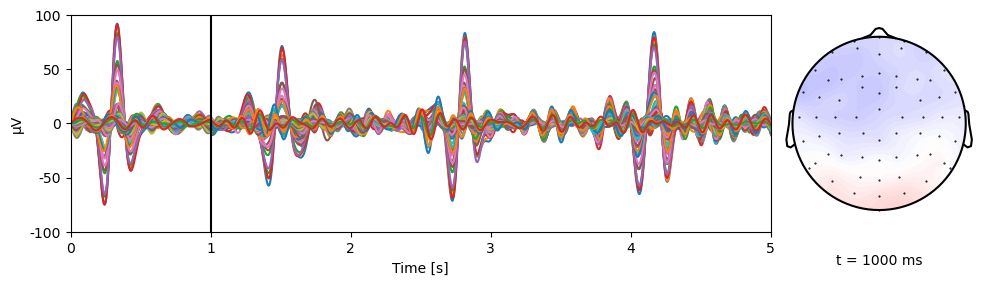

In [28]:
# Plot topographic EEG butterfly plot
t0 = 0
xlim = [t0, t0 + 5]
p = eelbrain.plot.TopoButterfly(raw, t=t0+1, xlim=xlim, vmax=1e-4, h=3, w=10, clip='circle')

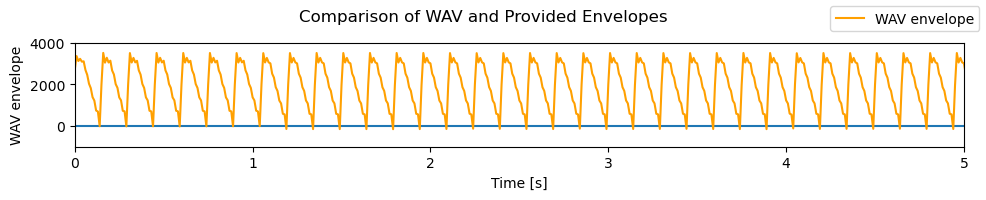

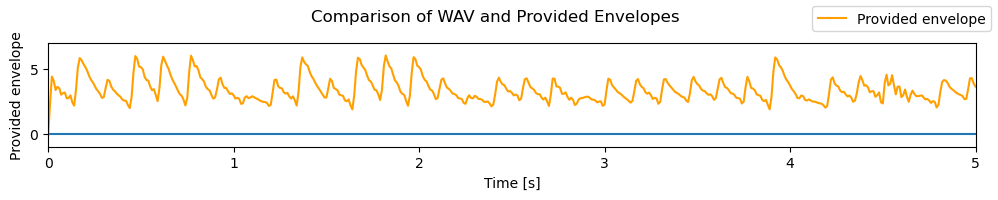

In [29]:
# Compare WAV envelope to provided (MIDI) envelope
# Demonstrates why using WAV envelopes is more reliable than MIDI files in this context


# WAV ENVELOPE

# Define trial index to inspect
trial_idx = 0  # corresponds to stimulus "1.wav"

# Load the WAV file for this trial
wav = eelbrain.load.wav(STIMULUS_DIR / f"{trial_idx+1}.wav")

# Compute its envelope
wav_envelope = wav.envelope()

# Resample to 100 Hz for TRF-style alignment
wav_envelope = eelbrain.resample(wav_envelope, 100)


# PROVIDED ENVELOPE

# Load the provided envelope from dataStim.mat
stim_mat = loadmat(EEG_DIR / "dataStim.mat", struct_as_record=False, squeeze_me=True)
stim = stim_mat["stim"]
stim_fs = int(stim.fs)

# Extract the precomputed envelope
provided_envelope = stim.data[0][trial_idx]

# Create an NDVar for the provided envelope
time = eelbrain.UTS(0, 1/stim_fs, len(provided_envelope))
provided_env_ndvar = eelbrain.NDVar(provided_envelope, (time,), name='provided_envelope')

# Resample to 100 Hz
provided_env_ndvar = eelbrain.resample(provided_env_ndvar, 100)


# Assign names for legend using .copy(name=...)
wav_envelope_named = wav_envelope.copy(name='WAV envelope')
provided_env_named = provided_env_ndvar.copy(name='Provided envelope')

# Plot with legend from names
p = eelbrain.plot.UTS(
    [wav_envelope_named],
    legend=True,
    axh=2, w=10, columns=1, xlim=(0, 5),
    title='Comparison of WAV and Provided Envelopes'
)
p.add_hline(0, zorder=0)

p = eelbrain.plot.UTS(
    [provided_env_named],
    legend=True,
    axh=2, w=10, columns=1, xlim=(0, 5),
    title='Comparison of WAV and Provided Envelopes'
)
p.add_hline(0, zorder=0)

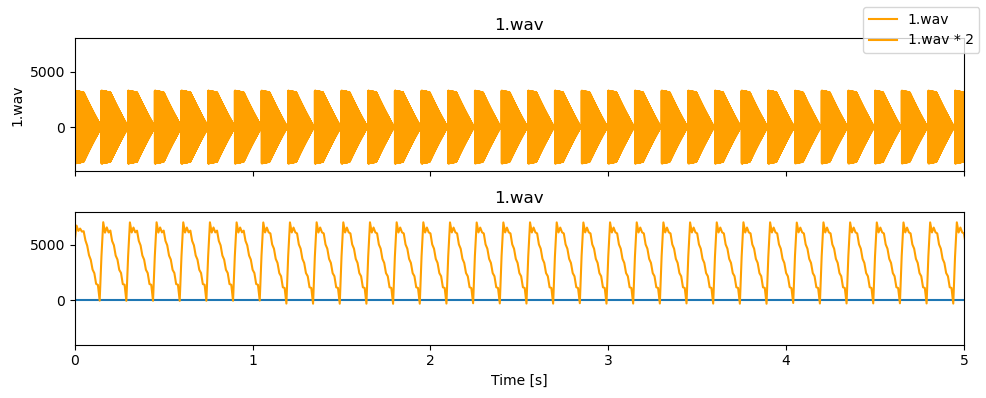

In [30]:
# Load the sound file corresponding to trigger 1
wav = eelbrain.load.wav(STIMULUS_DIR / f'1.wav')

# Compute the acoustic envelope
envelope = wav.envelope()

# Filter the envelope
envelope = eelbrain.resample(envelope, 100)

# Visualize the first 5 seconds
p = eelbrain.plot.UTS([wav, envelope * 2], axh=2, w=10, columns=1, xlim=5)

# Add y=0 as reference
p.add_hline(0, zorder=0)

In [31]:
# Generate the acoustic envelope for all trials in this dataset
envelopes = []
for stimulus_id in events['event']:
    song_id = stimulus_id % 10
    song_id = song_id if song_id != 0 else 10
    wav = eelbrain.load.wav(STIMULUS_DIR / f'{song_id}.wav')
    envelope = wav.envelope()
    envelope = eelbrain.resample(envelope, 100)
    envelopes.append(envelope)

# Add the envelopes to the events table
events['envelope'] = envelopes

# Add a second predictor corresponding to acoustic onsets
events['onsets'] = [envelope.diff('time').clip(0) for envelope in envelopes]

events

#,i_start,trigger,event,envelope,onsets
0,1,1,1,<NDVar '1.wa...,<NDVar '1.wa...
1,79963,2,2,<NDVar '2.wa...,<NDVar '2.wa...
2,157481,3,3,<NDVar '3.wa...,<NDVar '3.wa...
3,218059,4,4,<NDVar '4.wa...,<NDVar '4.wa...
4,286458,5,5,<NDVar '5.wa...,<NDVar '5.wa...
5,369824,6,6,<NDVar '6.wa...,<NDVar '6.wa...
6,469978,7,7,<NDVar '7.wa...,<NDVar '7.wa...
7,557065,8,8,<NDVar '8.wa...,<NDVar '8.wa...
8,648670,9,9,<NDVar '9.wa...,<NDVar '9.wa...
9,716256,10,10,<NDVar '10.w...,<NDVar '10.w...


In [32]:
# Extract the stimulus duration (in seconds) from the envelopes
events['duration'] = eelbrain.Var([envelope.time.tstop for envelope in events['envelope']])
events

#,i_start,trigger,event,envelope,onsets,duration
0,1,1,1,<NDVar '1.wa...,<NDVar '1.wa...,158.04
1,79963,2,2,<NDVar '2.wa...,<NDVar '2.wa...,153.1
2,157481,3,3,<NDVar '3.wa...,<NDVar '3.wa...,119.29
3,218059,4,4,<NDVar '4.wa...,<NDVar '4.wa...,134.5
4,286458,5,5,<NDVar '5.wa...,<NDVar '5.wa...,164.73
5,369824,6,6,<NDVar '6.wa...,<NDVar '6.wa...,198.31
6,469978,7,7,<NDVar '7.wa...,<NDVar '7.wa...,172.17
7,557065,8,8,<NDVar '8.wa...,<NDVar '8.wa...,181.21
8,648670,9,9,<NDVar '9.wa...,<NDVar '9.wa...,133.17
9,716256,10,10,<NDVar '10.w...,<NDVar '10.w...,177.1


In [33]:
# Extract EEG data corresponding exactly to the timing of the envelopes
events['eeg'] = eelbrain.load.mne.variable_length_epochs(events, 0, tstop='duration', decim=5, connectivity='auto')
events

Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 79016 original time points (prior to decimation) ...
0 bad epochs dropped
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 76546 original time points (prior to decimation) ...
0 bad epochs dropped
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 59641 original time points (prior to decimation) ...
0 bad epochs dropped
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 67246 original time points (prior to decimation) ...
0 bad epochs dropped
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items a

#,i_start,trigger,event,envelope,onsets,duration,eeg
0,1,1,1,<NDVar '1.wa...,<NDVar '1.wa...,158.04,<NDVar: 64 s...
1,79963,2,2,<NDVar '2.wa...,<NDVar '2.wa...,153.1,<NDVar: 64 s...
2,157481,3,3,<NDVar '3.wa...,<NDVar '3.wa...,119.29,<NDVar: 64 s...
3,218059,4,4,<NDVar '4.wa...,<NDVar '4.wa...,134.5,<NDVar: 64 s...
4,286458,5,5,<NDVar '5.wa...,<NDVar '5.wa...,164.73,<NDVar: 64 s...
5,369824,6,6,<NDVar '6.wa...,<NDVar '6.wa...,198.31,<NDVar: 64 s...
6,469978,7,7,<NDVar '7.wa...,<NDVar '7.wa...,172.17,<NDVar: 64 s...
7,557065,8,8,<NDVar '8.wa...,<NDVar '8.wa...,181.21,<NDVar: 64 s...
8,648670,9,9,<NDVar '9.wa...,<NDVar '9.wa...,133.17,<NDVar: 64 s...
9,716256,10,10,<NDVar '10.w...,<NDVar '10.w...,177.1,<NDVar: 64 s...


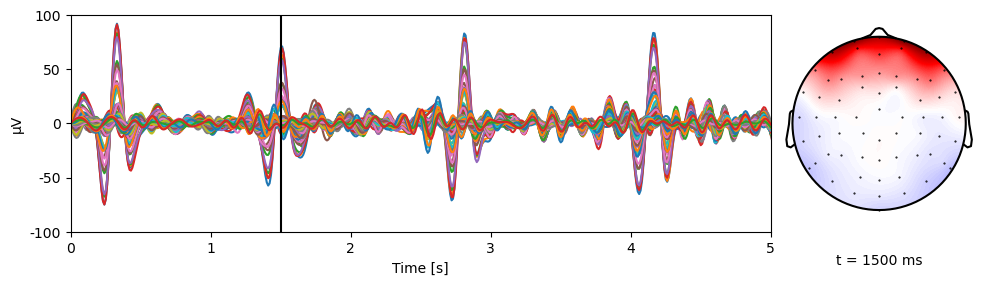

In [34]:
# Plot the first 5 seconds of EEG of the first trial
p = eelbrain.plot.TopoButterfly(events[0, 'eeg'], t=1.5, xlim=5, vmax=1e-4, h=3, w=10, clip='circle')

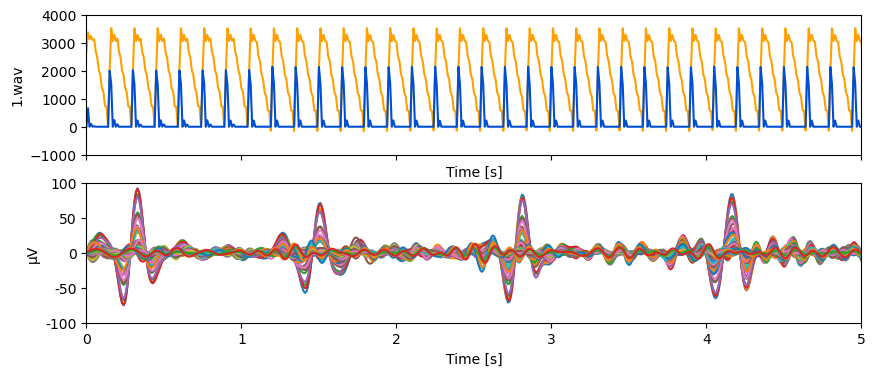

In [35]:
# Plot EEG alongside the representations of the sound that was presented
fig, axes = pyplot.subplots(2, 1, sharex=True, figsize=(10, 4))
p = eelbrain.plot.UTS([[events[0, 'envelope'], events[0, 'onsets']]], xlim=5, axes=axes[0])
p = eelbrain.plot.Butterfly(events[0, 'eeg'], xlim=5, vmax=1e-4, axes=axes[1])

In [36]:
# Estimate the TRF
trf = eelbrain.boosting('eeg', 'envelope', -0.150, 0.750, data=events, basis=0.050, partitions=4, error='l1')

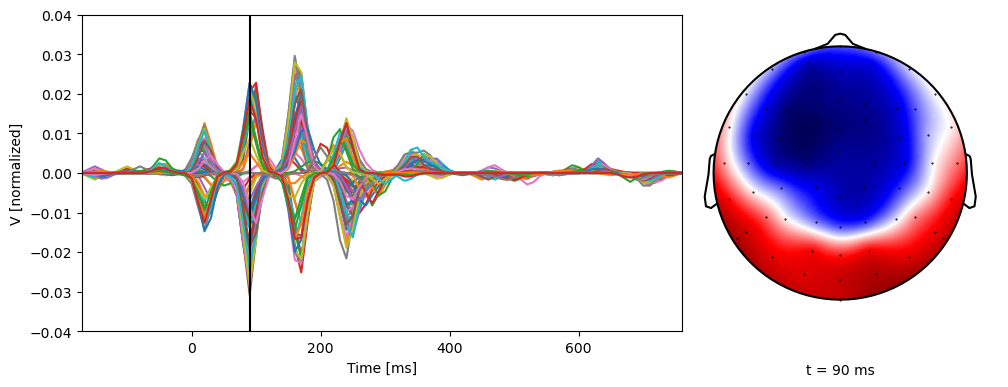

In [38]:
# Plot the TRF
t = trf.h.std('sensor').argmax('time')
p = eelbrain.plot.TopoButterfly(trf.h, t=t, w=10, h=4, clip='circle')

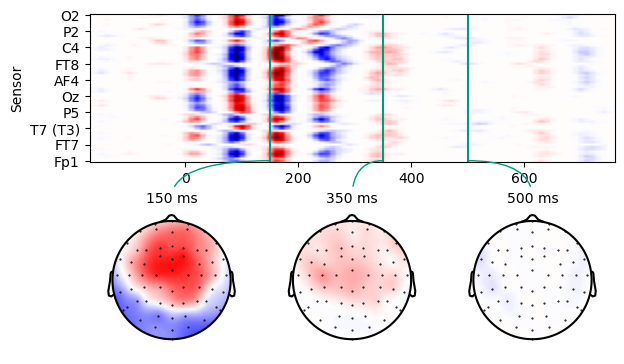

In [39]:
# Alternative visualization as array image
p = eelbrain.plot.TopoArray(trf.h, t=[0.150, 0.350, 0.500], w=6, h=4, clip='circle')

In [40]:
# Estimate the predicted power
trf_cv = eelbrain.boosting('eeg', 'envelope', -0.150, 0.750, data=events, basis=0.050, partitions=4, test=True, error='l1')

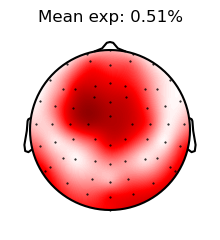

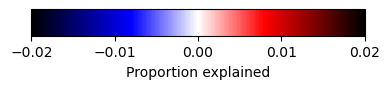

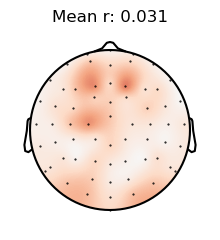

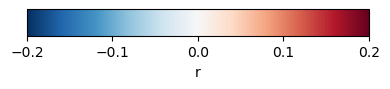

In [42]:
# Plot the predictive power across sensors, including the average across all sensors in each figure title
title = f"Mean exp: {trf_cv.proportion_explained.mean('sensor'):.2%}"
p = eelbrain.plot.Topomap(trf_cv.proportion_explained, clip='circle', title=title)
pcb = p.plot_colorbar('Proportion explained')

title = f"Mean r: {trf_cv.r.mean('sensor'):.2}"
p = eelbrain.plot.Topomap(trf_cv.r, clip='circle', title=title)
pcb = p.plot_colorbar()

In [44]:
# Train envelope decoder
decoder = eelbrain.boosting('envelope', 'eeg', -0.600, 0.200, data=events, partitions=4, basis=0.05, error='l1')

In [45]:
# Train onsets decoder
decoder_onsets = eelbrain.boosting('onsets', 'eeg', -0.600, 0.200, data=events, partitions=4, basis=0.05, error='l1')

In [46]:
# Create the data structure for one subject and one band
# trf and trf_cv are saved for future research; decoder, decoder_onsets, and trials are used in this paper

all_data = {
    'trf': trf,
    'trf_cv': trf_cv,
    'decoder': decoder,
    'decoder_onsets': decoder_onsets,
    'trials': {}
}

# Loop through all trials
for trial_num in range(30):
    
    # Normalize the EEG      
    eeg_one_event = events[trial_num, 'eeg'] / decoder.x_scale
    # Predict the envelope by convolving the decoder with the EEG
    y_pred = eelbrain.convolve(decoder.h, eeg_one_event, name='predicted envelope')

    # Normalize trial envelope and compute correlation with prediction
    y = events[trial_num, 'envelope']
    y = y - decoder.y_mean
    y /= decoder.y_scale / y_pred.std()
    y.name = 'envelope'
    r = eelbrain.correlation_coefficient(y, y_pred)
    
    # Normalize the EEG      
    eeg_one_event_onsets = events[trial_num, 'eeg'] / decoder_onsets.x_scale
    # Predict the onsets by convolving the decoder with the EEG
    y_pred_onsets = eelbrain.convolve(decoder_onsets.h, eeg_one_event_onsets, name='predicted onsets')

    # Normalize trial onsets and compute correlation with prediction
    y_onsets = events[trial_num, 'onsets']
    y_onsets = y_onsets - decoder_onsets.y_mean
    y_onsets /= decoder_onsets.y_scale / y_pred_onsets.std()
    y_onsets.name = 'onsets'
    r_onsets = eelbrain.correlation_coefficient(y_onsets, y_pred_onsets)
    
    # Store trial data
    trial_data = {
        'y_pred': y_pred,
        'y': y,
        'r': r,
        'y_pred_onsets': y_pred_onsets,
        'y_onsets': y_onsets,
        'r_onsets': r_onsets
    }
    
    # Add to trials dictionary
    all_data['trials'][f'trial{trial_num}'] = trial_data
    
    print(f"Processed trial {trial_num}: envelope r={r}, onsets r={r_onsets}")

# Save everything at once
with open('sub19_theta', 'wb') as f:
    pickle.dump(all_data, f)

print(f"✓ Saved all {len(all_data['trials'])} trials to sub19_theta")

Processed trial 0: envelope r=0.30392284815615445, onsets r=0.20016492396564703
Processed trial 1: envelope r=0.2413431575528257, onsets r=0.1677282843726363
Processed trial 2: envelope r=0.1270769652622423, onsets r=0.08190797128673596
Processed trial 3: envelope r=0.2083340037760886, onsets r=0.09956533399024468
Processed trial 4: envelope r=0.0915316252587136, onsets r=0.06711090504196882
Processed trial 5: envelope r=0.16879034303763252, onsets r=0.08728566691092444
Processed trial 6: envelope r=0.24125747406417813, onsets r=0.1386020884194907
Processed trial 7: envelope r=0.20152723858405547, onsets r=0.115076613440686
Processed trial 8: envelope r=0.15786300679233273, onsets r=0.1096292543112183
Processed trial 9: envelope r=0.19930314975713254, onsets r=0.10176651036268873
Processed trial 10: envelope r=0.3813881534198011, onsets r=0.2444441557046059
Processed trial 11: envelope r=0.31947997361112407, onsets r=0.2273631910444749
Processed trial 12: envelope r=0.08787213319674113